# 機械学習_効果測定 回帰
選択したデータ : auto-mpg.csv

k分割交差検証で複数モデルの性能を評価し、最終的にはラッソ回帰でモデルを作成しました。  
モデルを決めるまでの流れを以下に示します。

## ※ matplotlib日本語化のためのライブラリのインストール
### ▶ 以下を実行してください。

In [1]:
!pip install japanize-matplotlib
import japanize_matplotlib

import pandas as pd

     |████████████████████████████████| 4.1 MB 3.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=8c5418a8236c46d1ff7114feba5f8813047ee27178ce0ac05310b5de19e4ee42
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


CSVの内容は以下の通り

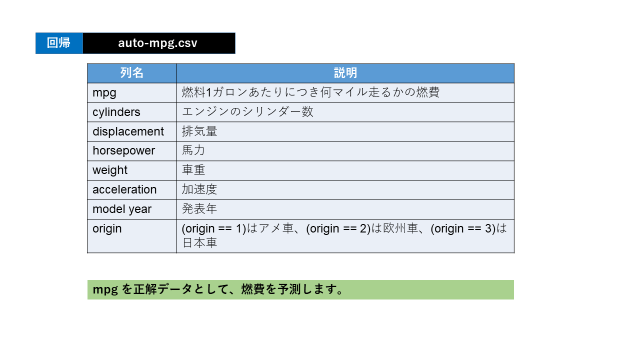

## ファイルの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('auto_mgp.csv')

# 正しく読み込めていることを確認するため、内容を表示する
df.head()

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1
3,3,16.0,8,304.0,150.0,3433,12.0,70,1
4,4,17.0,8,302.0,140.0,3449,10.5,70,1


CSVファイルに元からindex相当の列が存在する。  
特徴量として使わないだけなので、このまま作業を続ける。

In [3]:
# データの規模感を確認しておく
print(df.shape[0],'行')
print(df.shape[1],'列')

398 行
9 列


## 質的データの内容確認

質的データとしては、Model Year、Originが存在している。  
ダミー変数化したものを特徴量として使用する際、予測で使用する種類がデータとして揃っているかどうかを確認する。

### Model Year

In [4]:
df['Model Year'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

70～82の毎年のデータが存在することが分かった。  
今回は70～82年の範囲で燃費を予測する前提で、特徴量に加える予定とする。

### Origin

In [5]:
df['Origin'].unique()

array([1, 3, 2])

データの説明に記載されている3種類のデータが揃っていることを確認できた。  
今回はこの3種類の範囲で燃費を予測する前提で、特徴量に加える予定とする。

## 外れ値の確認

極端な外れ値は予測精度に影響を与えるため、外れ値の有無を確認する。  
今回は散布図を使い目視で確認する。

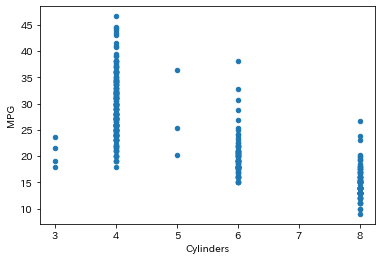

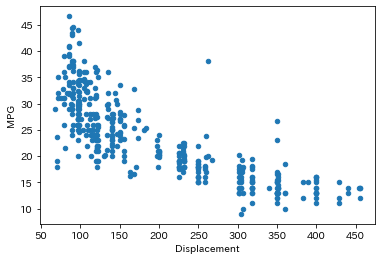

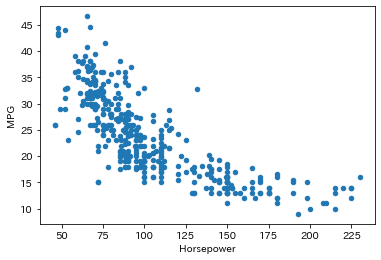

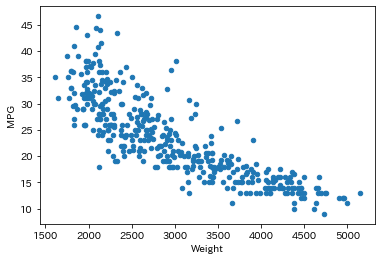

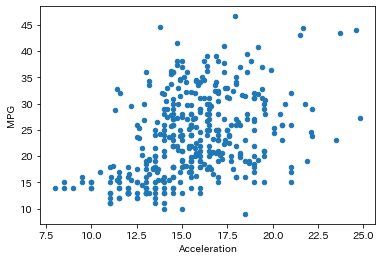

In [6]:
df.plot(kind='scatter', x='Cylinders', y='MPG')
df.plot(kind='scatter', x='Displacement', y='MPG')
df.plot(kind='scatter', x='Horsepower', y='MPG')
df.plot(kind='scatter', x='Weight', y='MPG')
df.plot(kind='scatter', x='Acceleration', y='MPG')

Displacementの以下のものを外れ値として考えた

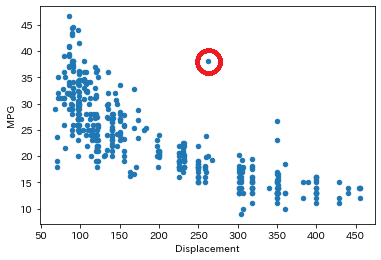

In [7]:
# 該当レコードの内容を確認する
df[ (df['Displacement'] > 250) & (df['MPG'] > 35)]

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,387,38.0,6,262.0,85.0,3015,17.0,82,1


In [8]:
# 後の確認で、外れ値を除去した方が決定係数が下がったため、今回は外れ値は残しておくこととした

out_line1 = df[ (df['Displacement'] > 250) & (df['MPG'] > 35)].index
print(out_line1)
# df = df.drop(out_line1, axis = 0)

Int64Index([387], dtype='int64')


## 欠損値の確認

In [9]:
# 欠損値があると学習できないため、欠損値の有無を確認
# 各列の欠損値の個数を確認する
df.isnull().sum()

Unnamed: 0      0
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
# 欠損値のある行の内容を確認
df[ df['Horsepower'].isnull() ]

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,32,25.0,4,98.0,NaN,2046,19.0,71,1
126,126,21.0,6,200.0,NaN,2875,17.0,74,1
330,330,40.9,4,85.0,NaN,1835,17.3,80,2
336,336,23.6,4,140.0,NaN,2905,14.3,80,1
354,354,34.5,4,100.0,NaN,2320,15.8,81,2
374,374,23.0,4,151.0,NaN,3035,20.5,82,1


In [11]:
# Horsepowerの欠損値をまずは平均値で穴埋めし、予測性能が低い場合は改めて穴埋め方法を考える
df_fillna = df.fillna( df.mean() )

# 欠損値が穴埋めできていることを確認する
df_fillna.isnull().sum()

Unnamed: 0      0
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

## ダミー変数化

全てのデータの種類が揃った状態でダミー変数化したいため、訓練＆テストデータ、検証データに分ける前にダミー変数化する

In [12]:
# Model Yearをダミー変数化
model_year_dummied = pd.get_dummies(df_fillna['Model Year'], drop_first=True)

# 意図通りにダミー変数化の列ができていることを確認する
model_year_dummied.head()

,71,72,73,74,75,76,77,78,79,80,81,82
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Originalをダミー変数化
origin_dummied = pd.get_dummies(df_fillna['Origin'], drop_first=True)

# 意図通りにダミー変数化の列ができていることを確認する
origin_dummied.head()

,2,3
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [14]:
# 一連のデータが揃ったデータフレーム(df_dummied)を作成する
# 元のデータフレームにダミー変数化したものを結合する
df_dummied = pd.concat([df_fillna, model_year_dummied, origin_dummied], axis=1)

# 元々のindex相当の列、ダミー変数化前の列は分析に使用しないので削除する
df_dummied = df_dummied.drop(['Unnamed: 0', 'Model Year', 'Origin'], axis=1)

# 意図通りにデータフレームを作成できているか確認する
df_dummied.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,71,72,73,74,75,76,77,78,79,80,81,82,2,3
0,18.0,8,307.0,130.0,3504,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15.0,8,350.0,165.0,3693,11.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,18.0,8,318.0,150.0,3436,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16.0,8,304.0,150.0,3433,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.0,8,302.0,140.0,3449,10.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# データフレームの形状を確認しておく
print(df_dummied.shape[0],'行')
print(df_dummied.shape[1],'列')

398 行
20 列


## 特徴量、正解データの切り出し

In [16]:
# 特徴量を切り出す
X = df_dummied.loc[ : , 'Cylinders':]
X.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,71,72,73,74,75,76,77,78,79,80,81,82,2,3
0,8,307.0,130.0,3504,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,350.0,165.0,3693,11.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,318.0,150.0,3436,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,304.0,150.0,3433,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,302.0,140.0,3449,10.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# 列名が数値だと警告が出るのを抑制するため、全て文字列の列名にしておく
X.columns = ['Cylinders','Displacement','Horsepower','Weight','Acceleration','Y71','Y72','Y73','Y74','Y75','Y76','Y77','Y78','Y79','Y80','Y81','82','Eur','Jpn']

In [18]:
# 正解データを切り出す
# 標準化できるよう、DataFrameで取得しておく
y = df_dummied[ ['MPG'] ]
y.head()

,MPG
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


## k分割交差検証でモデルの性能を確認する

モデルを変えて検証するため、処理を関数化(learn)しておく

In [19]:
# k分割交差検証(回帰モデル)をインポート
from sklearn.model_selection import KFold

# cross_validateインポート
from sklearn.model_selection import cross_validate

# モデル、特徴量、正解データを引数で受け取り、k分割交差検証を行う
# 交差検証の結果はDataFrameに変換して返す
# * 評価指標は'r2(決定係数)'とする
# * 訓練データでの結果も取得する
def learn(model, X, y):
  # KFoldのオブジェクトを作成する
  kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

  result = cross_validate(model, X, y, cv=kf, scoring='r2', return_train_score = True)

  return pd.DataFrame(result)

### LinearRegression

In [20]:
# LinearRegressionをインポート
from sklearn.linear_model import LinearRegression

ダミー変数化まで完了したデータでの性能を検証する

In [21]:
# 回帰モデルを生成する
model = LinearRegression()

# 交差検証の実施
result = learn(model, X, y)

# 検証結果の確認
print('train_scoreの平均:',result['train_score'].mean())
print('test_scoreの平均:',result['test_score'].mean())

train_scoreの平均: 0.8565232043715916
test_scoreの平均: 0.835977837976212


PolynomialFeaturesで多項式特徴量、交互作用特徴量を追加したデータでの性能を検証する

In [22]:
from sklearn.preprocessing import StandardScaler

# 多項式特徴量、交互作用特徴量を作成する前に、各列を標準化する
scaler_x = StandardScaler()
X_sc = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_sc = scaler_y.fit_transform(y)

In [23]:
from sklearn.preprocessing import PolynomialFeatures

# 2乗列と交互作用項の追加
pf = PolynomialFeatures(degree = 2, include_bias = False)

X_sc_pf = pf.fit_transform(X_sc) 
X_sc_pf = pd.DataFrame(X_sc_pf)
X_sc_pf.head()

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,1.498191,1.090604,0.669196,0.630870,-1.295498,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
1,1.498191,1.503514,1.586599,0.854333,-1.477038,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
2,1.498191,1.196232,1.193426,0.550470,-1.658577,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
3,1.498191,1.061796,1.193426,0.546923,-1.295498,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
4,1.498191,1.042591,0.931311,0.565841,-1.840117,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649


In [24]:
X_sc_pf.shape

(398, 209)

特徴量の列が209列もあり、LinearRegressionでは過学習が起きると考えられるが、一応検証する

In [25]:
# 交差検証の実施
result = learn(model, X_sc_pf, y_sc)

# 検証結果の確認
print('train_scoreの平均:',result['train_score'].mean())
print('test_scoreの平均:',result['test_score'].mean())

train_scoreの平均: 0.9466331962829002
test_scoreの平均: -9.22206099588373e+23


予想通り、過学習が起きている

### Ridge

In [26]:
# Ridgeをインポート
from sklearn.linear_model import Ridge

ダミー変数化＋標準化まで完了したデータで、alphaを変えながら性能を検証する

In [27]:
# 検証結果を集計しやすいように、データフレームに格納しておく
result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])

# モデルを生成する
for i in range(1, 300, 5):
  a = i / 10
  model = Ridge(alpha = a)

  result = learn(model, X_sc, y_sc)
  print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

alpha=0.1 train_score=0.8565215856574412 test_score=0.8360269644502683
alpha=0.6 train_score=0.8564698228071927 test_score=0.8362068460384158
alpha=1.1 train_score=0.8563581235522311 test_score=0.8362952380699868
alpha=1.6 train_score=0.8562005798413563 test_score=0.836312079269458
alpha=2.1 train_score=0.8560079632874433 test_score=0.8362727079007284
alpha=2.6 train_score=0.8557885784195743 test_score=0.8361890348713852
alpha=3.1 train_score=0.8555488753824786 test_score=0.8360703870735474
alpha=3.6 train_score=0.8552938959546379 test_score=0.8359241221511795
alpha=4.1 train_score=0.8550276022721446 test_score=0.8357560823338168
alpha=4.6 train_score=0.85475312184378 test_score=0.835570933335419
alpha=5.1 train_score=0.8544729320547237 test_score=0.835372420094963
alpha=5.6 train_score=0.854189000410878 test_score=0.8351635616284371
alpha=6.1 train_score=0.8539028920596422 test_score=0.8349468008067304
alpha=6.6 train_score=0.8536158528745524 test_score=0.8347241204274354
alpha=7.1 tr

リッジ回帰は過学習を抑えやすいため、PolynomialFeaturesで多項式特徴量、交互作用特徴量を追加したデータでの性能を検証する

In [28]:
# 検証結果を集計しやすいように、データフレームに格納しておく
result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])

# モデルを生成する
for i in range(1, 300, 5):
  a = i / 10
  model = Ridge(alpha = a)

  result = learn(model, X_sc_pf, y_sc)
  print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

alpha=0.1 train_score=0.9481957048454198 test_score=0.8114932730916722
alpha=0.6 train_score=0.9471482961850402 test_score=0.8329421780084921
alpha=1.1 train_score=0.9461972081456288 test_score=0.8405965053131407
alpha=1.6 train_score=0.9453722028905667 test_score=0.8448469704350398
alpha=2.1 train_score=0.9446369155463831 test_score=0.8476367123338548
alpha=2.6 train_score=0.9439670499126971 test_score=0.8496378614402772
alpha=3.1 train_score=0.9433471796268602 test_score=0.8511531795567431
alpha=3.6 train_score=0.942767076355819 test_score=0.8523424050553043
alpha=4.1 train_score=0.9422196140596896 test_score=0.8532993037559808
alpha=4.6 train_score=0.9416996072636412 test_score=0.8540833168160354
alpha=5.1 train_score=0.9412031434692674 test_score=0.8547343725993967
alpha=5.6 train_score=0.9407271814765596 test_score=0.8552805255173339
alpha=6.1 train_score=0.940269298717821 test_score=0.8557422040969594
alpha=6.6 train_score=0.9398275258131246 test_score=0.8561347205399829
alpha=7.

### Lasso

In [29]:
# ラッソ回帰
from sklearn.linear_model import  Lasso

ダミー変数化＋標準化まで完了したデータで、alphaを変えながら性能を検証する

In [30]:
result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])

# モデルを生成する
for i in range(1, 100, 5):
  a = i / 100
  model = Lasso(alpha = a)

  result = learn(model, X_sc, y_sc)
  print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

alpha=0.01 train_score=0.8504581290479379 test_score=0.8335379957027657
alpha=0.06 train_score=0.8149033911570595 test_score=0.7965435801354841
alpha=0.11 train_score=0.7686518888888073 test_score=0.7517764335176784
alpha=0.16 train_score=0.7198672108481443 test_score=0.7050911173607075
alpha=0.21 train_score=0.6742927748298202 test_score=0.6622599272410911
alpha=0.26 train_score=0.6358452890419547 test_score=0.6259158770838156
alpha=0.31 train_score=0.6018995882773086 test_score=0.593726141719767
alpha=0.36 train_score=0.5665951529431723 test_score=0.5593617529301055
alpha=0.41 train_score=0.5264443715086948 test_score=0.5204168570460764
alpha=0.46 train_score=0.48124233908417435 test_score=0.47639813235403017
alpha=0.51 train_score=0.4319720063638135 test_score=0.42744179742425714
alpha=0.56 train_score=0.3781796054474019 test_score=0.3735631944077314
alpha=0.61 train_score=0.3195483520274148 test_score=0.3145321209428892
alpha=0.66 train_score=0.2559935424538195 test_score=0.2503932

ラッソ回帰は不要な特徴量を削減できるため、PolynomialFeaturesで多項式特徴量、交互作用特徴量を追加してk分割交差検証を実施する

In [31]:
result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])
# モデルを生成する
for i in range(1, 100, 5):
  a = i / 100
  model = Lasso(alpha = a)

  result = learn(model, X_sc_pf, y_sc)
  print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

alpha=0.01 train_score=0.9189045418980377 test_score=0.866402576561161
alpha=0.06 train_score=0.8744867726133366 test_score=0.8518792719035766
alpha=0.11 train_score=0.8300370750180038 test_score=0.80901212333549
alpha=0.16 train_score=0.803365854699153 test_score=0.784417247668611
alpha=0.21 train_score=0.7780874527193775 test_score=0.7590408018828197
alpha=0.26 train_score=0.7476005060283928 test_score=0.7292745722536711
alpha=0.31 train_score=0.712313480036398 test_score=0.694579838522644
alpha=0.36 train_score=0.6726315906953824 test_score=0.6558564953698263
alpha=0.41 train_score=0.628142903635929 test_score=0.6117492424278128
alpha=0.46 train_score=0.5792967272682352 test_score=0.5620721581577083
alpha=0.51 train_score=0.5257399354969774 test_score=0.5067651759452174
alpha=0.56 train_score=0.4673976538257153 test_score=0.4466609699983817
alpha=0.61 train_score=0.40407188156906965 test_score=0.381322456167634
alpha=0.66 train_score=0.3356622324913759 test_score=0.3113706948750521


## Lassoで前処理を改善

k分割交差検証の結果、PolynomialFeaturesで多項式特徴量、交互作用特徴量を追加したデータで、ラッソ回帰を用いることにする。  
チューニングとして、欠損値の穴埋め方法の変更を試す。  

Horsepowerと他の列の関係を確認する

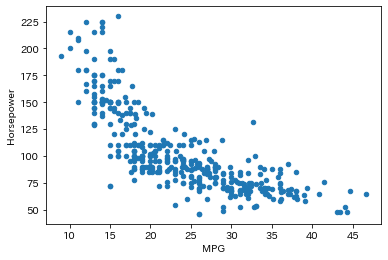

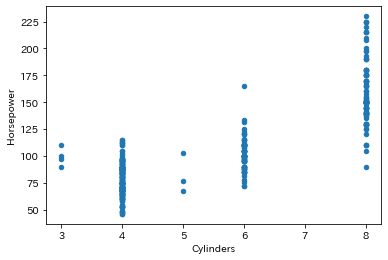

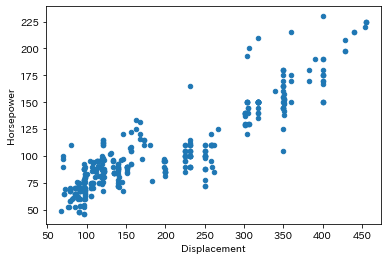

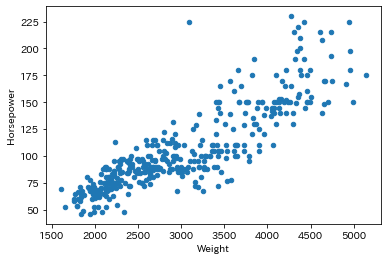

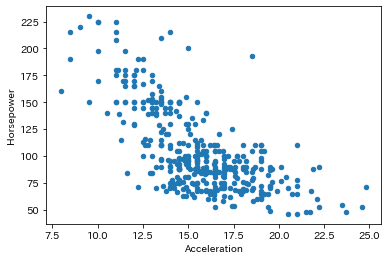

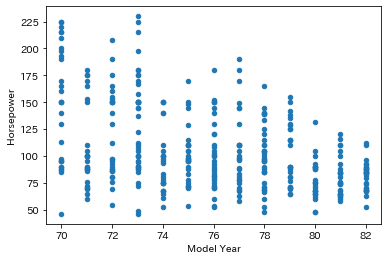

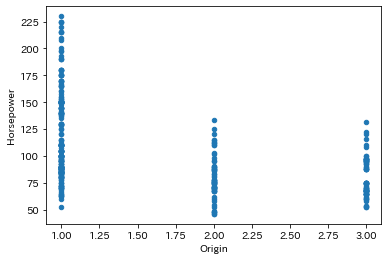

In [32]:
for colname in df.columns:
  if colname == 'Horsepower' or colname == 'Unnamed: 0' : continue
  df.plot(kind='scatter', x=colname, y='Horsepower')

散布図より、HorsepowerはCylinderなどと相関関係がある様子で、単純な平均値よりも方法を変えると性能がでるかもしれない。  
Horsepowerを予測するモデルを作成した穴埋めを試す。

### Horsepowerを予測するモデルを作成する


In [33]:
# Horsepowerと関係性の強い列を調べる
df.corr()['Horsepower'].map(abs).sort_values(ascending=False)

Horsepower      1.000000
Displacement    0.897257
Weight          0.864538
Cylinders       0.842983
MPG             0.778427
Acceleration    0.689196
Origin          0.455171
Unnamed: 0      0.422901
Model Year      0.416361
Name: Horsepower, dtype: float64

相関係数が0.5以上で、数値データである'Displacement','Weight','Cylinders','Acceleration'を使用する

In [34]:
# 欠損値のある行は取り除く
df_dropna = df.dropna(axis=0)

# Horsepowerを予測するモデルの特徴量を切り出す
X_horsepower = df_dropna[['Displacement','Weight','Cylinders','Acceleration']]
X_horsepower.head()

,Displacement,Weight,Cylinders,Acceleration
0,307.0,3504,8,12.0
1,350.0,3693,8,11.5
2,318.0,3436,8,11.0
3,304.0,3433,8,12.0
4,302.0,3449,8,10.5


In [35]:
# Horsepowerを予測するモデルの正解データを切り出す
y_horsepower = df_dropna['Horsepower']
y_horsepower.head()

0    130.0
1    165.0
2    150.0
3    150.0
4    140.0
Name: Horsepower, dtype: float64

In [36]:
# LinearRegressionのモデルを作成
model_horsepower = LinearRegression()
model_horsepower.fit(X_horsepower, y_horsepower)

LinearRegression()

### Horsepowerを予測するモデルで欠損値を穴埋め

In [37]:
# dfから欠損値のある行を抜き出す
non_data = df.loc[ df['Horsepower'].isnull() ]


# 欠損行の入力に利用する特徴量だけを抜き出して、モデルで予測
predict_data = non_data[['Displacement','Weight','Cylinders','Acceleration']]
predicted_data = model_horsepower.predict(predict_data)

df_fillna2 = df.copy()
# 欠損行のHorsepowerのマスを抜き出して、predicted_dataの値を代入
df_fillna2.loc[df['Horsepower'].isnull(), 'Horsepower'] = predicted_data

In [38]:
# 穴埋め結果を確認
df_fillna2[ df['Horsepower'].isnull()]

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,32,25.0,4,98.0,58.456456,2046,19.0,71,1
126,126,21.0,6,200.0,94.817453,2875,17.0,74,1
330,330,40.9,4,85.0,60.338130,1835,17.3,80,2
336,336,23.6,4,140.0,104.846195,2905,14.3,80,1
354,354,34.5,4,100.0,79.768228,2320,15.8,81,2
374,374,23.0,4,151.0,79.457320,3035,20.5,82,1


### ダミー変数化

In [39]:
# 一連のデータが揃ったデータフレーム(df_dummied2)を作成する
# 予測値で穴埋めしたデータフレームにダミー変数化したものを結合する
df_dummied2 = pd.concat([df_fillna2, model_year_dummied, origin_dummied], axis=1)

# 元々のindex相当の列、ダミー変数化前の列は分析に使用しないので削除する
df_dummied2 = df_dummied2.drop(['Unnamed: 0', 'Model Year', 'Origin'], axis=1)

# 意図通りにデータフレームを作成できているか確認する
df_dummied2.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,71,72,73,74,75,76,77,78,79,80,81,82,2,3
0,18.0,8,307.0,130.0,3504,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15.0,8,350.0,165.0,3693,11.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,18.0,8,318.0,150.0,3436,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16.0,8,304.0,150.0,3433,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.0,8,302.0,140.0,3449,10.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# データフレームの形状を確認しておく
print(df_dummied2.shape[0],'行')
print(df_dummied2.shape[1],'列')

398 行
20 列


## 特徴量、正解データの切り出し

In [41]:
# 特徴量を切り出す
X2 = df_dummied2.loc[ : , 'Cylinders':]
X2.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,71,72,73,74,75,76,77,78,79,80,81,82,2,3
0,8,307.0,130.0,3504,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,350.0,165.0,3693,11.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,318.0,150.0,3436,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,304.0,150.0,3433,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,302.0,140.0,3449,10.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
X2.shape

(398, 19)

In [43]:
# 列名が数値だと警告が出るのを抑制するため、全て文字列の列名にしておく
X2.columns = ['Cylinders','Displacement','Horsepower','Weight','Acceleration','Y71','Y72','Y73','Y74','Y75','Y76','Y77','Y78','Y79','Y80','Y81','82','Eur','Jpn']

In [44]:
# 正解データを切り出す
# 標準化できるよう、DataFrameで取得しておく
y2 = df_dummied[['MPG']]
y2.head()

,MPG
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


In [45]:
# 多項式特徴量、交互作用特徴量を作成する前に、各列を標準化する
scaler_x2 = StandardScaler()
X2_sc = scaler_x2.fit_transform(X2)

scaler_y2 = StandardScaler()
y2_sc = scaler_y2.fit_transform(y2)

In [46]:
# 2乗列と交互作用項の追加
pf2 = PolynomialFeatures(degree = 2, include_bias = False)

X2_sc_pf = pf.fit_transform(X2_sc) 
X2_sc_pf = pd.DataFrame(X2_sc_pf)
X2_sc_pf.head()

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,1.498191,1.090604,0.675911,0.630870,-1.295498,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
1,1.498191,1.503514,1.589116,0.854333,-1.477038,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
2,1.498191,1.196232,1.197742,0.550470,-1.658577,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
3,1.498191,1.061796,1.197742,0.546923,-1.295498,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649
4,1.498191,1.042591,0.936827,0.565841,-1.840117,-0.275092,-0.275092,-0.334263,-0.269771,-0.28552,...,0.078591,0.081477,0.129508,0.13951,0.084469,0.134264,0.144633,0.213415,0.229895,0.247649


## 最終的なモデルの作成（Lasso）

In [47]:
result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])

# モデルを生成する
for i in range(1, 100, 5):
  a = i / 100
  model = Lasso(alpha = a)

  result = learn(model, X2_sc_pf, y2_sc)
  print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

alpha=0.01 train_score=0.9181711983645282 test_score=0.8676184307737083
alpha=0.06 train_score=0.8744605089751362 test_score=0.8526482182718
alpha=0.11 train_score=0.8300918717745922 test_score=0.8096713677303038
alpha=0.16 train_score=0.8033676445664282 test_score=0.7851263699237208
alpha=0.21 train_score=0.7780765368945033 test_score=0.7596102634568669
alpha=0.26 train_score=0.7474867776522502 test_score=0.7294881855015359
alpha=0.31 train_score=0.7122238088645849 test_score=0.6945810900076109
alpha=0.36 train_score=0.6726518985089335 test_score=0.6558525113514492
alpha=0.41 train_score=0.6281427721902835 test_score=0.6117489424575767
alpha=0.46 train_score=0.5792969117746711 test_score=0.5620723488611827
alpha=0.51 train_score=0.5257397550247742 test_score=0.5067649843016981
alpha=0.56 train_score=0.46739764956095514 test_score=0.4466609659038253
alpha=0.61 train_score=0.4040718816384469 test_score=0.3813224562522655
alpha=0.66 train_score=0.3356622324913759 test_score=0.31137069487

In [48]:
# 範囲を限定して更に細かくalphaを調整
result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])

# モデルを生成する
for i in range(1, 10, 1):
  a = i / 100
  model = Lasso(alpha = a)

  result = learn(model, X2_sc_pf, y2_sc)
  print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

alpha=0.01 train_score=0.9181711983645282 test_score=0.8676184307737083
alpha=0.02 train_score=0.9067146148323261 test_score=0.8723729460484966
alpha=0.03 train_score=0.8984540327840254 test_score=0.8697165235299679
alpha=0.04 train_score=0.8896381310308683 test_score=0.8645004860106997
alpha=0.05 train_score=0.8821263047781628 test_score=0.8590013239276162
alpha=0.06 train_score=0.8744605089751362 test_score=0.8526482182718
alpha=0.07 train_score=0.8660454063281977 test_score=0.8447316428807887
alpha=0.08 train_score=0.8569878308248807 test_score=0.8361267156294854
alpha=0.09 train_score=0.8474280613525277 test_score=0.8264778829931755
==test_scoreが最大のケース==
alpha          0.020000
train_score    0.906715
test_score     0.872373
Name: 1, dtype: float64


検証結果でtest_scoreが最大となったパラメータで、最終的なモデルを作成する

In [49]:
from sklearn.model_selection import train_test_split

# 訓練用とテスト用にデータを分割
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_sc_pf,  y2_sc, test_size = 0.2, random_state = 0)

# これまでの検証結果から、test_scoreが最大だったalphaを使用する
model = Lasso(alpha = 0.02)
model.fit(X2_train, y2_train)

# 決定係数を確認する
# 検証結果の確認
print('訓練データでの決定係数:',model.score(X2_train, y2_train))
print('テストデータでの決定係数:',model.score(X2_test, y2_test))

訓練データでの決定係数: 0.9028704415311459
テストデータでの決定係数: 0.8818434064768217


完成したモデル、スケーラーを保存

In [50]:
# pickleライブラリのインポート
import pickle

# モデルを保存
with open('lasso.pkl', 'wb') as f:
  pickle.dump(model, f)

# スケーラー(特徴量)を保存
with open('scaler_x.pkl', 'wb') as f:
  pickle.dump(scaler_x2, f)

# スケーラー(正解データ)を保存
with open('scaler_y.pkl', 'wb') as f:
  pickle.dump(scaler_y2, f)
